# Clustering Sampling Techniques Comparison

This notebook compares the performance of different clustering sampling techniques on the nlbse24 dataset.<br><br>

Given the number of samples to draw K, the clustering sampling methods compared are the following:
- K-means with K clusters (it plans to draw one sample from each cluster)(the drawn sample is the centroid of the cluster)
- K-medoids with K clusters (it plans to draw one sample from each cluster)(the drawn sample is the medoid of the cluster)
- K-means with D clusters (it plans to draw S samples from each clusters, so that S*D=K)(the drawn samples are those closer to the centroid of the cluster)
- K-medoids with D clusters (it plans to draw S samples from each clusters, so that S*D=K)(the drawn samples are those closer to the medoid of the cluster)<br><br>

First, a Grid Search on the number of clusters and the number of samples to draw and on the clustering method (means or medoid) is performed to find the best hyperparameters for the clustering sampling techniques.<br><br>

Then, the best hyperparameters are used to train and the clustering sampling techniques on the nlbse24 dataset. The plot of the clustering and of the sample drawn is stored in the apposite folders.<br><br>

For further information, please check the MLflow experiments for name "Clustering_Sampling".

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from syntetic_issue_report_data_generation.config import RAW_DATA_DIR, DATASET_CONFIGs, DATA_DIR, EMBEDDING_DIR, FIGURES_DIR, SAMPLES_DIR
from syntetic_issue_report_data_generation.utils.clustering_sampling import ClusteringSampling
from syntetic_issue_report_data_generation.utils.text_encoder import Encoder

dataset_name = "nlbse24_train"
dataset_folder = "nlbse24"

c:\Users\utente\Desktop\uni\anno 2 magistrale\semestre 1\software engineering for ai\Capibara\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset, get all the bodies and extract embeddings for them. The embeddings are exracted using gemmma encoder and then reduced to 2 dimensional vectors using UMAP.<br>
The embeddings are saved in the embeddings folder

In [3]:
# Load the dataset
df = pd.read_csv(
            RAW_DATA_DIR / f"{DATASET_CONFIGs[dataset_name]['data_path']}",
            sep=DATASET_CONFIGs[dataset_name].get('sep', ','),
            encoding="utf-8",
        )

# Encode the bodies of the dataset, obtain the embeddings
bodies = [str(x) for x in df[DATASET_CONFIGs[dataset_name]["body_col"]].tolist()]

embeddings_path = EMBEDDING_DIR / "issue-report-classification" / dataset_folder / f"{dataset_name}_embeddings.npy"

if not os.path.exists(embeddings_path):
    encoder = Encoder()
    embeddings = encoder.encode(bodies, save=True, save_path=embeddings_path)
else:
    embeddings = np.load(embeddings_path)

In [4]:
embeddings.shape

(1500, 2)

To tune the hyperparameters of number of clusters, number of samples to draw and the clustering method (medoid or means), we can use a Grid Search.<br>
In the followig code we evaluate the clustering sampling performance using differen parameters for the hperparameters.<br><br>

The evaluation metrics used are:<br>
- Sampling metrics:<br>
    - Distributions mean norm similarity: the norm of the difference between the mean of the sample and the mean the original dataset<br>
    - Distributions std norm similarity: the norm of the difference between the std of the sample and the std the original dataset<br>
    - Kolmogorov-Smirnov Test: Compare the KS-test between the sample and the original dataset. Used to test if accept, with a confidence level c, the hypothesis that the sample comes from the same distribution of the original dataset.<br>
It is False if we can accept the hypothesis that the sample comes from the same distribution of the original dataset.<br>
- Clustering metrics:<br>
    - Silhouette score: Estimates the average distance among the clusters<br>
    - Mean squared error: Calculates the for each cluster, the squared distances between each sample and the centroid/medoid and then make the mean of these values<br>

In [ ]:
# n_clusters, n_samples hyperparameter tuning
n_clusters_values = [2, 5, 10, 20]
n_samples_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a dictionary to store the results
hp_results = {}

for n_clusters in n_clusters_values:
    for n_samples in n_samples_values:
        hp_results[(n_clusters, n_samples)] = {
            "means": {"samples": {}, "evaluation": {}},
            "medoid": {"samples": {}, "evaluation": {}},
        }

        print("evaluation for n_clusters = ", n_clusters, "and n_samples = ", n_samples)

        # define the clustering models
        clustering_models = {
            "means": ClusteringSampling(n_clusters=n_clusters, n_samples=n_samples, method="means"),
            "medoid": ClusteringSampling(n_clusters=n_clusters, n_samples=n_samples, method="medoid"),
        }

        # run the models
        for model_name, model in clustering_models.items():
            hp_results[(n_clusters, n_samples)][model_name]["samples"], hp_results[(n_clusters, n_samples)][model_name]["evaluation"] = model.train_and_eval(embeddings, dataset_name, save=False, save_figures_folder=None, save_samples_folder=None)

Here we plot the results of the hyper parameter tuning of the clustering sampling techniques.

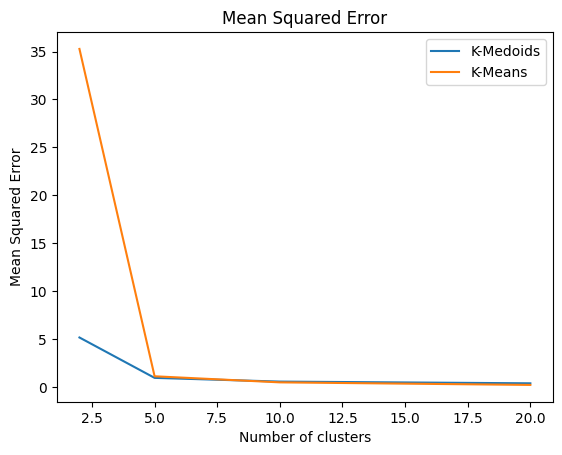

For the K-means
The best number of clusters for mse is 20
With a mse of 0.20207472737630208
For the K-medoid
The best number of clusters for mse is 20
With a mse of 0.369772705078125


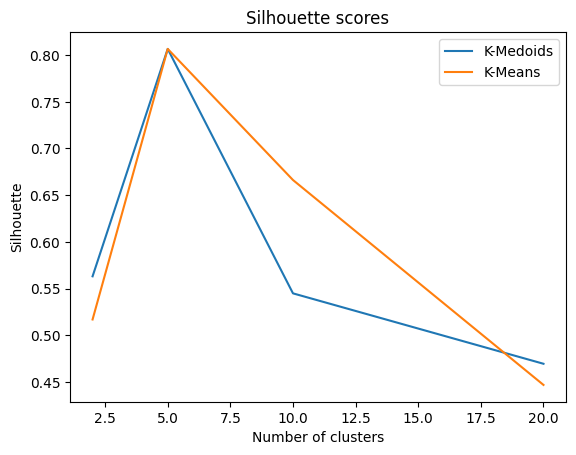

For the K-means
The best number of clusters for shiluette is 5
With a silhouette of 0.8066308498382568
For the K-medoid
The best number of clusters for shiluette is 5
With a silhouette of 0.8066308498382568


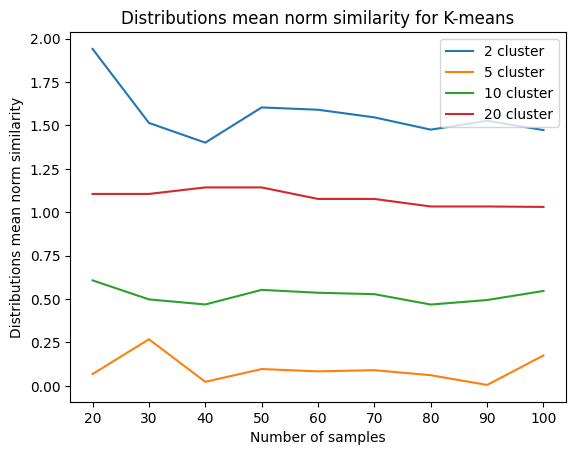

For the K-means
The best combination of number of clusters and number of samples for the mean distribution similarity is 5 clusters and 90 samples
With a mean similarity of 0.0052489564


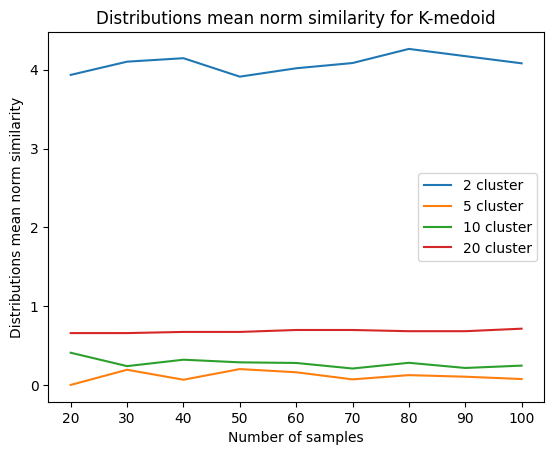

For the K-medoid
The best combination of number of clusters and number of samples for the mean distribution similarity is 5 clusters and 20 samples
With a mean similarity of 0.0038000795


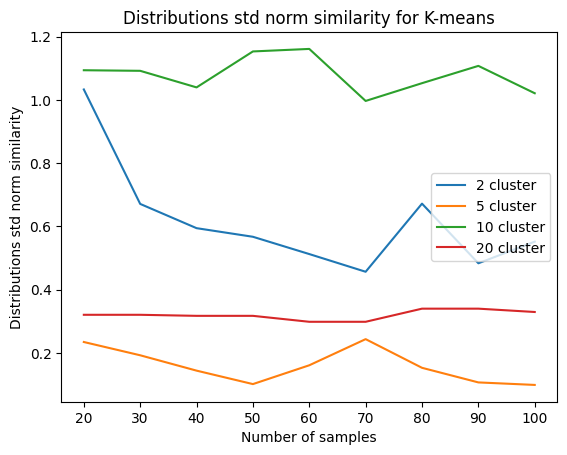

For the K-means
The best combination of number of clusters and number of samples for the std distribution similarity is 5 clusters and 100 samples
With a std similarity of 0.09857538


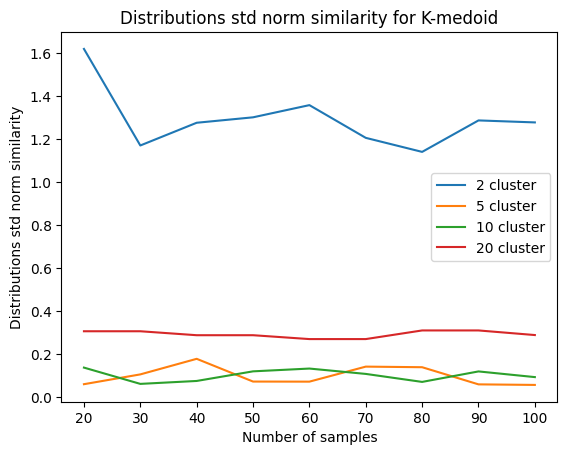

For the K-medoid
The best combination of number of clusters and number of samples for the std distribution similarity is 5 clusters and 100 samples
With a std similarity of 0.055438265


In [ ]:
# plot the resuls hyperparameter tuning

# MSE
# plot the mse in function of the number of clusters (this does not depend on the number of samples since it is a clustering metric)
# so, we fix a number of samples to 20 and pick the mse for the runs with that number of samples but various number of clusters
mse = {
    "medoid": np.array([v["medoid"]["evaluation"]["mse"] for k,v in hp_results.items() if k[1]==20]),
    "means": np.array([v["means"]["evaluation"]["mse"] for k,v in hp_results.items() if k[1]==20])
}

# plot the mse
plt.plot(n_clusters_values, mse["medoid"], label="K-Medoids")
plt.plot(n_clusters_values, mse["means"], label="K-Means")

plt.xlabel("Number of clusters")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error")
plt.legend()

plt.show()

# print best number of clusters according to the mse (the one with the lowest mse)
for method in ["means","medoid"]:
    print("For the K-"+method)
    best_n_clusters_mse = n_clusters_values[np.argmin(mse[method])]
    print("The best number of clusters for mse is "+str(best_n_clusters_mse))
    print("With a mse of "+str(np.min(mse[method])))


# Silhouette
# plot the silhouette in function of the number of clusters (this does not depend on the number of samples since it is a clustering metric)
silhouette = {
    "medoid": np.array([v["medoid"]["evaluation"]["silhouette"] for k,v in hp_results.items() if k[1]==20]),
    "means": np.array([v["means"]["evaluation"]["silhouette"] for k,v in hp_results.items() if k[1]==20])
}

# plot the silhouette
plt.plot(n_clusters_values, silhouette["medoid"], label="K-Medoids")
plt.plot(n_clusters_values, silhouette["means"], label="K-Means")

plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")
plt.title("Silhouette scores")
plt.legend()

plt.show()

# print best number of clusters according to the silhouette (the one with the highest silhouette)
for method in ["means","medoid"]:
    print("For the K-"+method)
    best_n_clusters_shiluette = n_clusters_values[np.argmax(silhouette[method])]
    print("The best number of clusters for shiluette is "+str(best_n_clusters_shiluette))
    print("With a silhouette of "+str(np.max(silhouette[method])))

# plot the distributions mean norm similarity
for method in ["means","medoid"]:
    for c in n_clusters_values:
        distributions_mean_norm_sim = [v[method]["evaluation"]["distributions_mean_norm_sim"] for k,v in hp_results.items() if k[0]==c]
        plt.plot(n_samples_values, distributions_mean_norm_sim,label=str(c)+" cluster")
    
    plt.xlabel("Number of samples")
    plt.ylabel("Distributions mean norm similarity")
    plt.title("Distributions mean norm similarity for K-"+method)
    plt.legend()
    
    plt.show()

    mean_sims = [v[method]["evaluation"]["distributions_mean_norm_sim"] for k,v in hp_results.items()]
    best_n_clusters_mean_norm = n_clusters_values[np.argmin(mean_sims)//(len(n_samples_values))]
    best_n_samples_mean_norm = n_samples_values[np.argmin(mean_sims)%(len(n_samples_values))]
    print("For the K-"+method)
    print("The best combination of number of clusters and number of samples for the mean distribution similarity is "+str(best_n_clusters_mean_norm)+" clusters and "+str(best_n_samples_mean_norm)+" samples")
    print("With a mean similarity of "+str(np.min(mean_sims)))

# plot the distributions std norm similarity
for method in ["means","medoid"]:
    for c in n_clusters_values:
        distributions_std_norm_sim = [v[method]["evaluation"]["distributions_std_norm_sim"] for k,v in hp_results.items() if k[0]==c]
        plt.plot(n_samples_values, distributions_std_norm_sim,label=str(c)+" cluster")
    
    plt.xlabel("Number of samples")
    plt.ylabel("Distributions std norm similarity")
    plt.title("Distributions std norm similarity for K-"+method)
    plt.legend()
    
    plt.show()

    std_sims = [v[method]["evaluation"]["distributions_std_norm_sim"] for k,v in hp_results.items()]
    best_n_clusters_std_norm = n_clusters_values[np.argmin(std_sims)//(len(n_samples_values))]
    best_n_samples_std_norm = n_samples_values[np.argmin(std_sims)%(len(n_samples_values))]
    print("For the K-"+method)
    print("The best combination of number of clusters and number of samples for the std distribution similarity is "+str(best_n_clusters_std_norm)+" clusters and "+str(best_n_samples_std_norm)+" samples")
    print("With a std similarity of "+str(np.min(std_sims)))

The hyperparameter tuning results have been showed in terms of:
- MSE
- Silhouette
- Distributions mean norm similarity
- Distributions std norm similarity

From these results, we can see how the most appropriate number of clusters for nlbse24 is 5 (this is highly higlithed by the silhouette score).<br><br>
The 5 clusters showed also the best results for the mean norm similarity and the std norm similarity between the sample and the original dataset, for both K-means and K-medoids.<br><br>
About the MSE, the best number of cluster found has been 20. This may be due to the fact that having more clusters, means leads to a situation in which samples are closer to the center of the cluster they belong to,<br><br>

Despite this, almost all clustering techniques were able to pass the Kolmogorov-Smirnov Test (only those with high number of samples and number of clusters equals to 2 had failed the test).<br><br>

About the best number of samples to pick, from the distribution metrics we can see how a number of samples of 20, 90 and 100 are the most appropriate (20 and 90 samples minimized the distribution mean similarity while the 100 samples minimized the distribution std similarity).<br><br>

Said this, about the distribution std similarity, the 20 samples had been the second best. Also, the 20 samples showd a lower distribution std similarity than the 90 samples. So, we can pick 20 samples as the best value for the number of samples to pick.<br><br>

Between K-meand and K-medoid, the second one was able to reach better results according to the used metrics in the most of the scenarios<br><br>

Resuming, the best results were obtained with the following parameters:
- K-medoid
- number of clusters: 5
- number of samples: 20

Here we run again the K-medoid sampling with 5 clusters and 20 samples to save the results of the evaluation and of the sampling

Initialized MLflow to track repo "se4ai2526-uniba/Capibara"

Repository se4ai2526-uniba/Capibara initialized!

🏃 View run Kmedoid_5_clusters_20_samples_nlbse24_train at: https://dagshub.com/se4ai2526-uniba/Capibara.mlflow/#/experiments/4/runs/fe29875b44df49ba9f4c321240c34a24
🧪 View experiment at: https://dagshub.com/se4ai2526-uniba/Capibara.mlflow/#/experiments/4


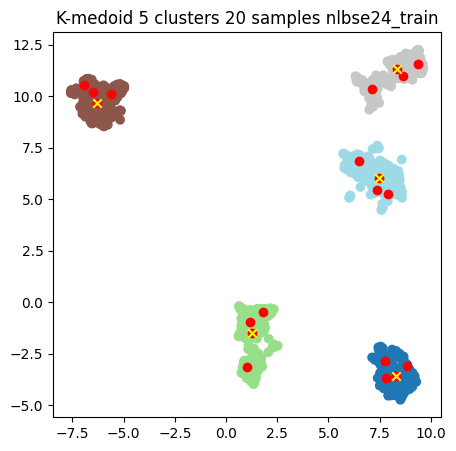

In [15]:
save_figures_folder = FIGURES_DIR / f"clustering_sampling/{dataset_folder}"
save_samples_folder = SAMPLES_DIR / f"issue-report-classification/{dataset_folder}"

best_sampling_model = ClusteringSampling(n_clusters=5, n_samples=20, method="medoid")
best_sample, best_evaluation = best_sampling_model.train_and_eval(embeddings, dataset_name=dataset_name, save=True, save_figures_folder=save_figures_folder, save_samples_folder=save_samples_folder)


plt.figure(figsize=(5,5))
plt.scatter(embeddings[:,0], embeddings[:,1], c=best_sample["labels"], cmap="tab20")
plt.scatter(best_sample["sample"][:,0], best_sample["sample"][:,1], color="red")
plt.scatter(best_sample["centers"][:,0], best_sample["centers"][:,1], color="yellow", marker="x")
plt.title("K-medoid 5 clusters 20 samples "+dataset_name)
plt.show()

In [13]:
print(best_evaluation)

{'distributions_mean_differece': array([0.00294518, 0.00240135], dtype=float32), 'distributions_std_differece': array([0.03862047, 0.04436064], dtype=float32), 'distributions_mean_norm_sim': 0.0038000795, 'distributions_std_norm_sim': 0.058816724, 'kst': False, 'silhouette': 0.8066308498382568, 'mse': 0.9374418131510417}
